Compare the EUV intensity profiles of a bright spot with the radio dynamic spectra

In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
# os.environ['CDF_LIB'] = '/home/peijin/cdf/cdf38_0-dist/lib'

import sys
import glob
import time
import requests
import argparse
import datetime
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.dates import DateFormatter
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

from astropy import units as u
from astropy.visualization import ImageNormalize, SqrtStretch, PercentileInterval

import sunpy.map
from sunpy import timeseries as ts
from sunpy.net import Fido, attrs as a

from scipy.ndimage import gaussian_filter
from solarmach import SolarMACH
import pyspedas
from pytplot import get_data
from spacepy import pycdf

mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

#plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'


'''
SDO/AIA Instrument
===================
94 A: Flaring regions.
171 A: Quiet corona, upper transition region.
193 A: Corona and hot flare plasma.
211 A: Active region corona.
'''




# Define custom tick formatter for y-axis
def custom_formatter(x, pos):
    return f'{x:.2f}'



def minmax_normalize(arr=None):
    '''
    Min-Max normalization.
    '''
    min_val = np.min(arr)
    max_val = np.max(arr)
    arr_norm = (arr - min_val) / (max_val - min_val)
    return arr_norm



def split_date(dt=None):
    '''
    Split a datetime object into year, month, and day, and return them as strings.
        dt: Datetime/Timestamp object.
    '''
    YEAR = dt.date().year
    MONTH = dt.date().month
    DAY = dt.date().day
    
    if DAY < 10:
        DAY = f'0{DAY}'
    else:
        DAY = f'{DAY}'
    
    if MONTH < 10:
        MONTH = f'0{MONTH}'
    else:
        MONTH = f'{MONTH}'
    
    return YEAR, MONTH, DAY


data_dir = '/Users/mnedal/DIAS/data'

def fetch_xrs(dt=None, year=None, month=None, day=None):
    '''
    Download GOES/XRS data.
        dt: Datetime/Timestamp object.
        Inputs: year, month, day.
    '''
    try:
        os.makedirs(f'{data_dir}/XRS', exist_ok=True)
    except:
        pass

    if year == 2019:
        # Check if the file doesn't exist
        file_path = f'{data_dir}/XRS/sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'

        if not os.path.exists(file_path):
            # get the data file
            URL = f'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes17/l2/data/xrsf-l2-flx1s_science/{year}/{month}/sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'
            response = requests.get(URL)
            open(os.path.join('{data_dir}/XRS', f'sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'), 'wb').write(response.content)

        goes = ts.TimeSeries(file_path)
    else:
        file_path = f'{data_dir}/XRS/sci_xrsf-l2-avg1m_g16_d{year}{month}{day}_v2-2-0.nc'
        
        if not os.path.exists(file_path):
            goes_result = Fido.search(a.Time(f'{dt.date()}', f'{dt.date()}'), a.Instrument('XRS'), a.goes.SatelliteNumber(16))
            goes_file = Fido.fetch(goes_result, path='./{instrument}/{file}')
            goes = ts.TimeSeries(goes_file)
        else:
            goes = ts.TimeSeries(file_path)
    return goes




def fetch_waves(dt=None, year=None, month=None, day=None):
    '''
    Download Wind/WAVES data.
        dt: Datetime/Timestamp object.
        Inputs: year, month, day.
    '''
    try:
        os.makedirs(f'{data_dir}/wind_data/waves/wav_h1/{year}', exist_ok=True)
    except:
        pass

    file_path = f'{data_dir}/wind_data/waves/wav_h1/{year}/wi_h1_wav_{year}{month}{day}_v01.cdf'
    
    if not os.path.exists(file_path):
        print('Wind/WAVES data file not exist!')
        print('Proceed to fetch data from the server ..')
        
        # get the data file
        URL = f'https://spdf.gsfc.nasa.gov/pub/data/wind/waves/wav_h1/{year}/wi_h1_wav_{year}{month}{day}_v01.cdf'
        response = requests.get(URL)
        open(os.path.join(f'{data_dir}/wind_data/waves/wav_h1/{year}', f'wi_h1_wav_{year}{month}{day}_v01.cdf'), 'wb').write(response.content)
        
        print('Wind/WAVES data is downloaded locally.')
        wind = pycdf.CDF(f'{data_dir}/wind_data/waves/wav_h1/{year}/wi_h1_wav_{year}{month}{day}_v01.cdf')
    else:
        print('Wind/WAVES data exists locally.')
        wind = pycdf.CDF(f'{data_dir}/wind_data/waves/wav_h1/{year}/wi_h1_wav_{year}{month}{day}_v01.cdf')
        
    wind_time = [mdates.date2num(tm) for tm in pd.to_datetime(wind.get('Epoch'))]
    RAD1_freq = np.array(wind.get('Frequency_RAD1'))
    RAD2_freq = np.array(wind.get('Frequency_RAD2'))
    TNR_freq = np.array(wind.get('Frequency_TNR'))
    RAD1_int = np.array(wind.get('E_VOLTAGE_RAD1'))
    RAD2_int = np.array(wind.get('E_VOLTAGE_RAD2'))
    TNR_int = np.array(wind.get('E_VOLTAGE_TNR'))

    wind_freq = np.concatenate((TNR_freq, RAD1_freq, RAD2_freq))
    wind_data = np.concatenate((TNR_int, RAD1_int, RAD2_int), axis=1)

    # Apply Gaussian smoothing
    smoothed_wind = gaussian_filter(wind_data, sigma=1)
        
    wind_norm = ImageNormalize(smoothed_wind, interval=PercentileInterval(97), clip=True)
    
    return wind_time, wind_freq, smoothed_wind, wind_norm



def fetch_STAswaves(year=None, month=None, day=None):
    '''
    Download STEREO/SWAVES data.
        Inputs: year, month, day.
    '''
    try:
        os.makedirs(f'{data_dir}/stereo_data', exist_ok=True)
    except:
        pass

    file_path = f'{data_dir}/stereo_data/stereo_level2_swaves_{year}{month}{day}_v02.cdf'

    if not os.path.exists(file_path):
        # get the data file
        URL = f'https://spdf.gsfc.nasa.gov/pub/data/stereo/combined/swaves/level2_cdf/{year}/stereo_level2_swaves_{year}{month}{day}_v02.cdf'
        response = requests.get(URL)
        open(os.path.join(f'{data_dir}/stereo_data', f'stereo_level2_swaves_{year}{month}{day}_v02.cdf'), 'wb').write(response.content)
    
    # read the data values
    cdf_stereo = pycdf.CDF(f'{data_dir}/stereo_data/stereo_level2_swaves_{year}{month}{day}_v02.cdf')
    time_ste = np.array(cdf_stereo.get('Epoch'))
    freq_ste = np.array(cdf_stereo.get('frequency'))
    data_ste_A = np.array(cdf_stereo.get('avg_intens_ahead'))

    # calculate the mean value in each row (freq channel)
    # and subtract it from each corresponding row
    df_ste_A = pd.DataFrame(data_ste_A.T)
    df_ste_mean = df_ste_A.mean(axis=1)
    data_ste_A = df_ste_A.sub(df_ste_mean, axis=0)

    # Apply Gaussian smoothing
    smoothed_ste_A = gaussian_filter(data_ste_A, sigma=1)

    ste_norm = ImageNormalize(smoothed_ste_A, interval=PercentileInterval(97), clip=True)

    return time_ste, freq_ste, smoothed_ste_A, ste_norm




def fetch_PSPfields(year=None, month=None, day=None, data_version=2):
    '''
    Download PSP/FIELDS data.
        Inputs: year, month, day.
    '''
    try:
        os.makedirs(f'{data_dir}/psp_data', exist_ok=True)
    except:
        pass

    hfr_file_path = f'psp_fld_l2_rfs_hfr_{year}{month}{day}_v0{data_version}.cdf'
    lfr_file_path = f'psp_fld_l2_rfs_lfr_{year}{month}{day}_v0{data_version}.cdf'
    
    HFR_URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_hfr/{year}/{month}/{hfr_file_path}'
    LFR_URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_lfr/{year}/{month}/{lfr_file_path}'

    hfr_response = requests.head(HFR_URL)
    lfr_response = requests.head(LFR_URL)

    if hfr_response.status_code == 200 and lfr_response.status_code == 200:
        # Files are available, proceed with download
        if not os.path.exists(hfr_file_path):
            response = requests.get(HFR_URL)
            open(os.path.join(f'{data_dir}/psp_data', hfr_file_path), 'wb').write(response.content)
        
        if not os.path.exists(lfr_file_path):
            response = requests.get(LFR_URL)
            open(os.path.join(f'{data_dir}/psp_data', lfr_file_path), 'wb').write(response.content)
        
        # load the PSP data
        cdf_psp_hfr = pycdf.CDF(os.path.join(f'{data_dir}/psp_data', hfr_file_path))
        cdf_psp_lfr = pycdf.CDF(os.path.join(f'{data_dir}/psp_data', lfr_file_path))

        # the min power scaled power spectral density (PSD) of 1e-16 is used as a threshold
        # convert pixels values to dB
        arr_lfr = np.array(cdf_psp_lfr.get('psp_fld_l2_rfs_lfr_auto_averages_ch0_V1V2'))
        Lp_lfr = 10*np.log10(arr_lfr/10**-16) # z-axis
        tm_lfr = np.array(cdf_psp_lfr.get('epoch_lfr')) # x-axis
        freq_lfr = np.array(cdf_psp_lfr.get('frequency_lfr_auto_averages_ch0_V1V2'))/10**6 # y-axis

        # convert pixels values to dB
        arr_hfr = np.array(cdf_psp_hfr.get('psp_fld_l2_rfs_hfr_auto_averages_ch0_V1V2'))
        Lp_hfr = 10*np.log10(arr_hfr/10**-16) # z-axis
        tm_hfr = np.array(cdf_psp_hfr.get('epoch_hfr')) # x-axis
        freq_hfr = np.array(cdf_psp_hfr.get('frequency_hfr_auto_averages_ch0_V1V2'))/10**6 # y-axis

        # clean the dyspec by subtracting the Mean intensity from each freq channel
        df_psp_hfr = pd.DataFrame(Lp_hfr.T)
        df_psp_lfr = pd.DataFrame(Lp_lfr.T)

        # concat the two arrays of both bands
        df_lfr = pd.DataFrame(df_psp_lfr)
        df_lfr.insert(loc=0, column='frequency', value=freq_lfr[0])
        df_lfr.set_index(['frequency'], inplace=True)

        df_hfr = pd.DataFrame(df_psp_hfr)
        df_hfr.insert(loc=0, column='frequency', value=freq_hfr[0])
        df_hfr.set_index(['frequency'], inplace=True)

        # drop the overlapped rows, take only the first row of the duplicated group
        df_psp = pd.concat([df_lfr, df_hfr])
        df_psp = df_psp.sort_index(axis=0)
        df_psp = df_psp[~df_psp.index.duplicated(keep='first')]
        df_psp.columns = max([tm_lfr, tm_hfr], key=len)
        
        # calculate the mean value in each row (freq channel)
        # and subtract it from each corresponding row
        df_psp_mean = df_psp.mean(axis=1)
        df_psp_submean = df_psp.sub(df_psp_mean, axis=0)
        
        # Check for NaN and -inf values and replace them with zero
        df_psp_submean.replace([np.nan, -np.inf], 0, inplace=True)

        # Apply Gaussian smoothing
        psp_submean_smooth = gaussian_filter(df_psp_submean, sigma=1)
        df_smoothed_psp = pd.DataFrame(psp_submean_smooth, index=df_psp.index, columns=df_psp.columns)

        psp_norm = ImageNormalize(psp_submean_smooth, interval=PercentileInterval(97), clip=True)
        
        return df_smoothed_psp, psp_norm
    
    else:
        # Files are not available
        print('PSP/FIELD data is not available on the website!\n')
        return None

In [10]:
t = pd.Timestamp('2021-09-18')

YEAR, MONTH, DAY = split_date(dt=t)
goes = fetch_xrs(dt=t, year=YEAR, month=MONTH, day=DAY)
wind_time, wind_freq, wind_data, wind_norm = fetch_waves(dt=t, year=YEAR, month=MONTH, day=DAY)
time_ste, freq_ste, data_ste_A, ste_norm = fetch_STAswaves(year=YEAR, month=MONTH, day=DAY)
df_psp, psp_norm = fetch_PSPfields(year=YEAR, month=MONTH, day=DAY, data_version=3)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

Wind/WAVES data exists locally.


In [12]:
# Load the EUV intensity profiles
df193 = pd.read_csv('./mean_intensities_193a.csv', names=['Datetime','avg_int'], index_col=0, skiprows=[0])
df193['Datetime'] = pd.to_datetime(df193['Datetime'])
df193.set_index('Datetime', inplace=True)

df211 = pd.read_csv('./mean_intensities_211a.csv', names=['Datetime','avg_int'], index_col=0, skiprows=[0])
df211['Datetime'] = pd.to_datetime(df211['Datetime'])
df211.set_index('Datetime', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: './mean_intensities_193a.csv'

PSP plot is ready.
STEREO plot is ready.
Wind plot is ready.
GOES plot is ready.


NameError: name 'df193' is not defined

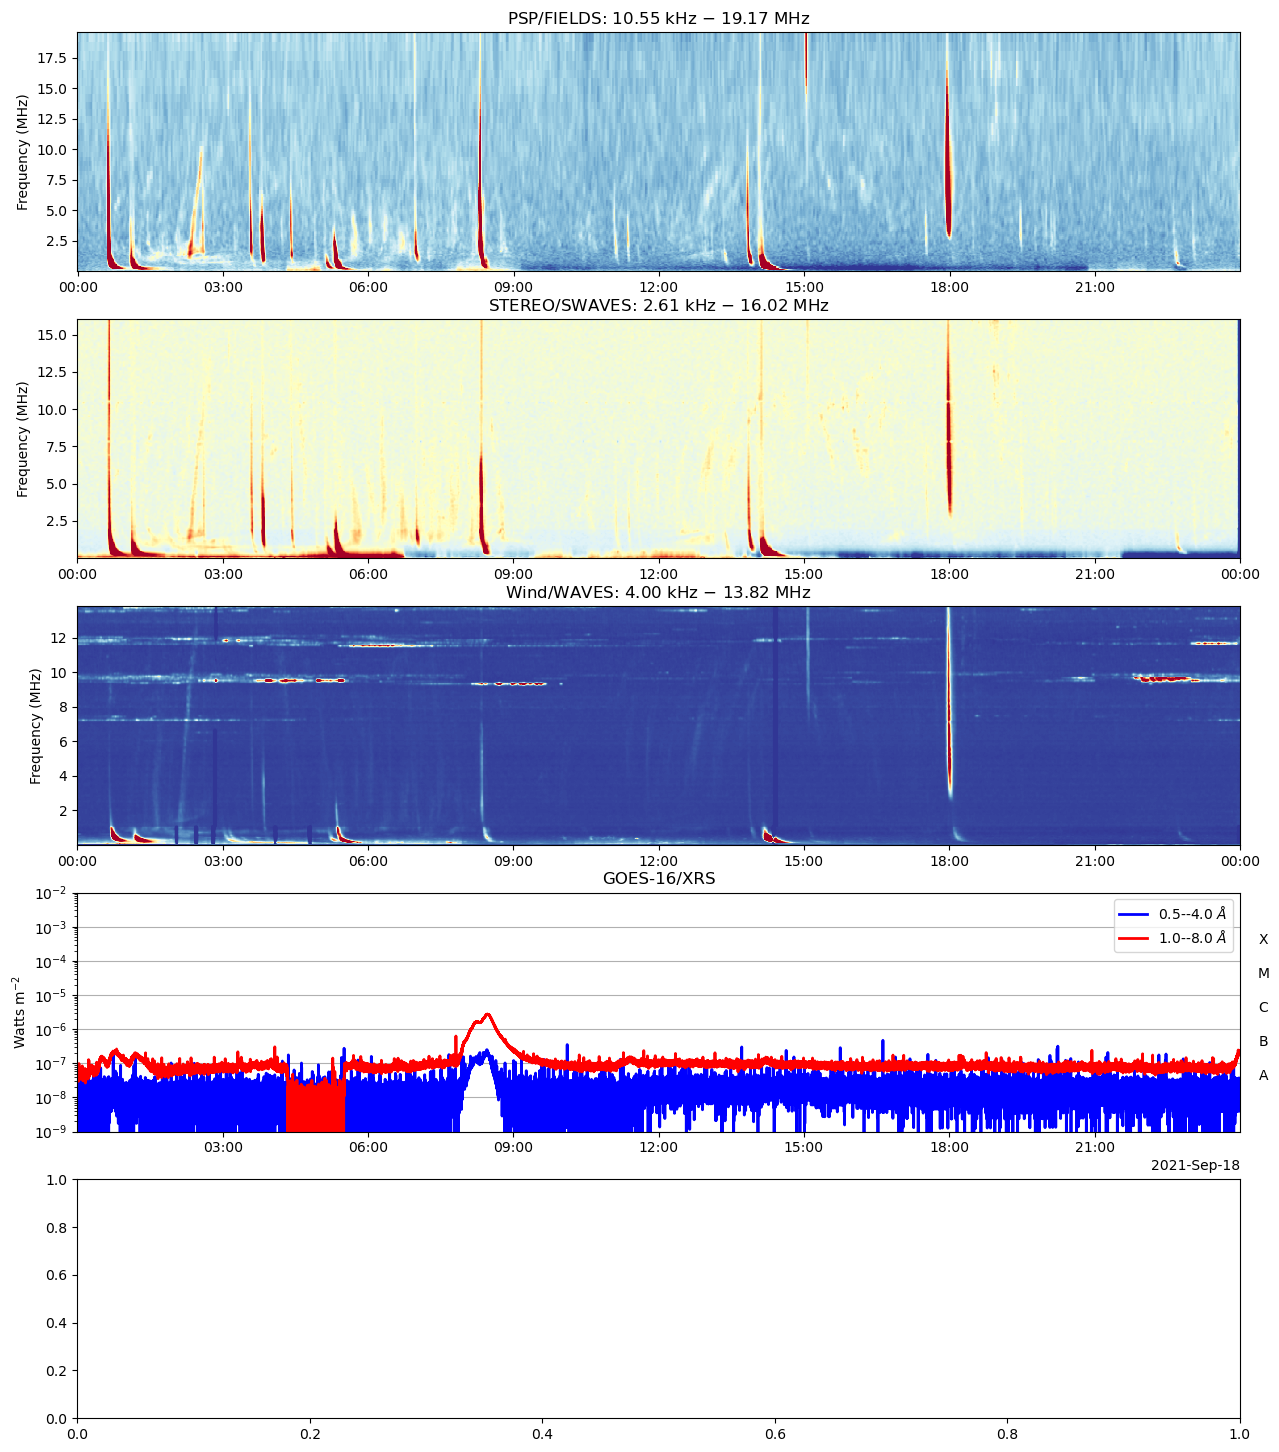

In [14]:
fig = plt.figure(figsize=[15,18])

ax1 = fig.add_subplot(511)
ax1.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
ax1.set_ylabel('Frequency (MHz)')
ax1.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
print('PSP plot is ready.')

ax2 = fig.add_subplot(512)
ax2.pcolormesh(time_ste,
               freq_ste/1e3,
               data_ste_A,
               norm=ste_norm,
               cmap='RdYlBu_r')
ax2.grid(False)
ax2.set_ylabel('Frequency (MHz)')
ax2.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
ax2.xaxis_date()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
print('STEREO plot is ready.')

ax3 = fig.add_subplot(513)
ax3.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax3.set_ylabel('Frequency (MHz)')
ax3.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
print('Wind plot is ready.')

ax4 = fig.add_subplot(514)
goes[0].plot(axes=ax4)
ax4.set_xlim(left=mdates.date2num(pd.Timestamp(str(goes[0].time_range.start))),
                 right=mdates.date2num(pd.Timestamp(str(goes[0].time_range.end))))
ax4.set_title(f"{goes[0].observatory}/{goes[0].source.upper()}")
print('GOES plot is ready.')

ax5 = fig.add_subplot(515)
ax5.plot(df193.index, df193['avg_int'], color='dodgerblue', label=r'AIA 193 $\AA$')
ax55 = ax5.twinx()
ax55.plot(df211.index, df211['avg_int'], color='darkorange', label=r'AIA 211 $\AA$')

# Change color of ticks and numbers on the right y-axis
ax55.tick_params(axis='y', colors='darkorange')
ax5.set_xlabel('Time (UT)')
ax5.set_ylabel(r'$<Intensity>$ (ct/s)')
ax5.grid(alpha=0.5)
ax5.xaxis_date()
ax5.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax5.set_xlim(df193.index[0], df193.index[-1])

# Combine legends into one box
lines, labels = ax5.get_legend_handles_labels()
lines2, labels2 = ax55.get_legend_handles_labels()
ax5.legend(lines + lines2, labels + labels2, loc='upper right')
print('EUV intensity profiles are ready.')

fig.tight_layout()
# fig.savefig(f'./multiwavelength_comparison_{t.date()}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Load the EUV intensity profiles, segments
aia_channel = 94

df = pd.read_csv(f'/home/mnedal/DIAS/mean_intensities_segments_{aia_channel}a.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

# Replace values meeting condition with NaN in all columns
df = df.applymap(lambda x: np.nan if x < 0.5 else x)

# Pick this column to plot
col = 'avg_int_seg1'

df.head()

avg_int_seg1  avg_int_seg2  avg_int_seg3  \
datetime                                                            
2021-09-18 00:00:11.120      1.235434      1.636264      1.517153   
2021-09-18 00:01:11.120      1.222288      1.622843      1.529998   
2021-09-18 00:02:11.120      1.245311      1.647665      1.533096   
2021-09-18 00:03:11.120      1.246935      1.648632      1.517583   
2021-09-18 00:04:11.120      1.240321      1.643477      1.531793   

                         avg_int_seg4  avg_int_seg5  avg_int_seg6  \
datetime                                                            
2021-09-18 00:00:11.120      1.238402      2.890360      1.847120   
2021-09-18 00:01:11.120      1.249259      2.880600      1.840126   
2021-09-18 00:02:11.120      1.249659      2.901950      1.858446   
2021-09-18 00:03:11.120      1.239351      2.898444      1.861900   
2021-09-18 00:04:11.120      1.250720      2.891307      1.856512   

                         avg_int_seg7  avg_int_seg8  avg_int_seg9  \
datetime                                                            
2021-09-18 00:00:11.120      1.790558      2.557709      3.136731   
2021-09-18 00:01:11.120      1.811736      2.577692      3.128582   
2021-09-18 00:02:11.120      1.812820      2.583537      3.113945   
2021-09-18 00:03:11.120      1.797461      2.567969      3.133723   
2021-09-18 00:04:11.120      1.804577      2.569124      3.141242   

                         avg_int_seg10  avg_int_seg11  avg_int_seg12  \
datetime                                                               
2021-09-18 00:00:11.120       1.764011       1.657346       2.625050   
2021-09-18 00:01:11.120       1.758309       1.674863       2.644898   
2021-09-18 00:02:11.120       1.747620       1.662800       2.629456   
2021-09-18 00:03:11.120       1.762916       1.663107       2.639077   
2021-09-18 00:04:11.120       1.772166       1.671308       2.638855   

                         avg_int_seg13  avg_int_seg14  avg_int_seg15  \
datetime                                                               
2021-09-18 00:00:11.120       1.897461       1.860995       1.642004   
2021-09-18 00:01:11.120       1.901943       1.865525       1.647437   
2021-09-18 00:02:11.120       1.889088       1.852806       1.638788   
2021-09-18 00:03:11.120       1.907857       1.871970       1.636915   
2021-09-18 00:04:11.120       1.905009       1.869384       1.637743   

                         avg_int_seg16  
datetime                                
2021-09-18 00:00:11.120       1.631956  
2021-09-18 00:01:11.120       1.636960  
2021-09-18 00:02:11.120       1.633213  
2021-09-18 00:03:11.120       1.625035  
2021-09-18 00:04:11.120       1.629186

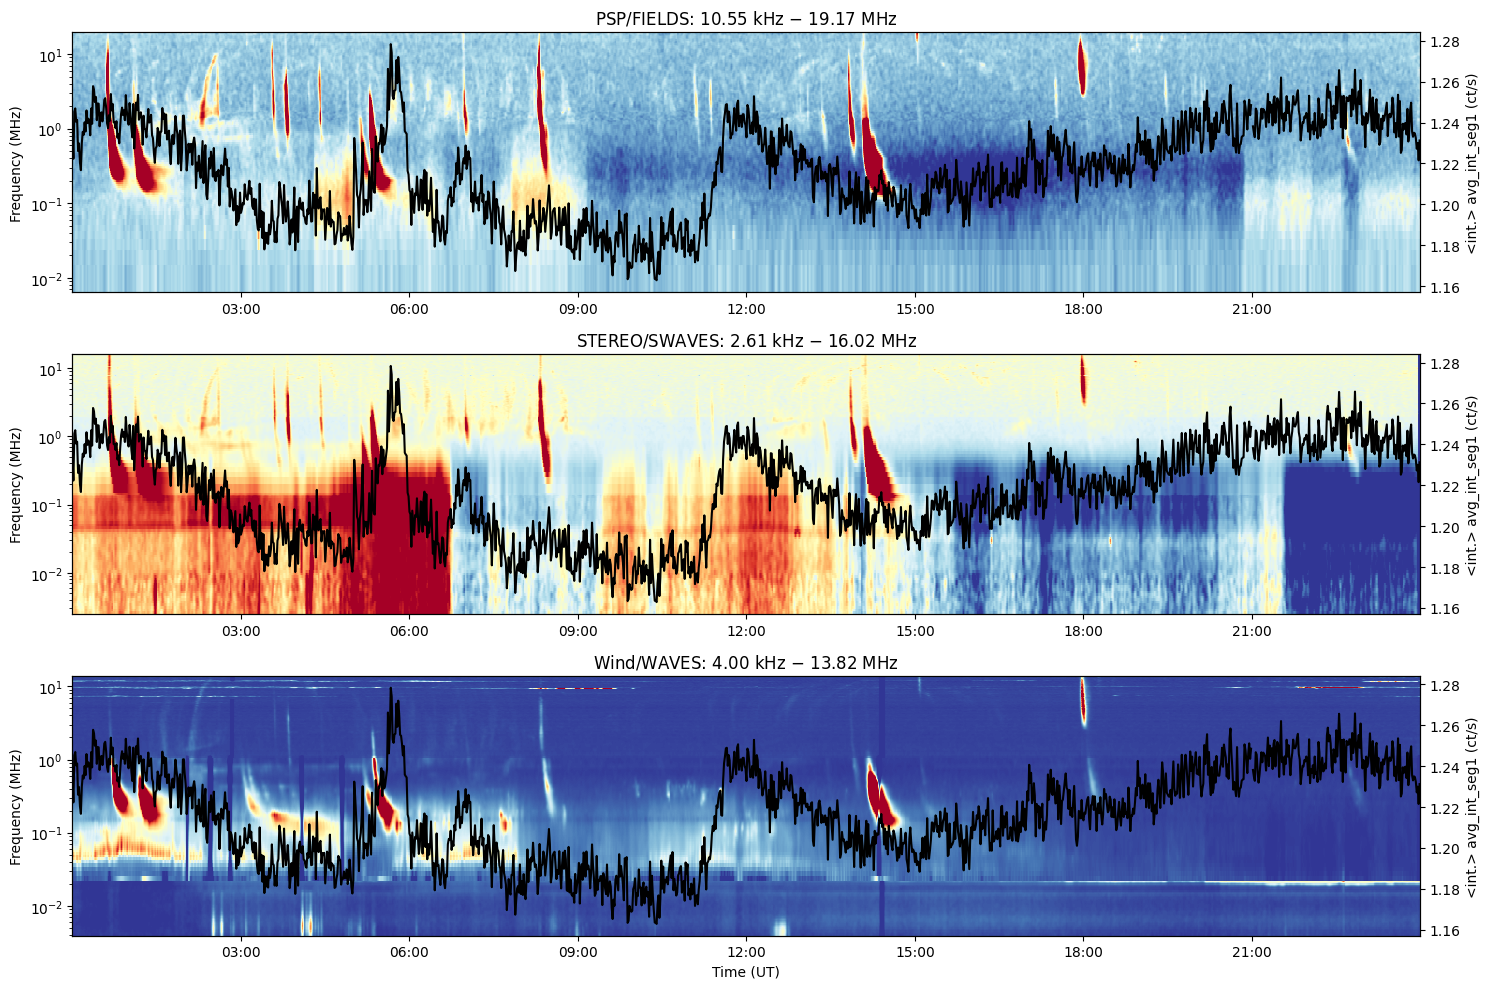

In [135]:
fig = plt.figure(figsize=[15,10])

ax = fig.add_subplot(311)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

ax = fig.add_subplot(312)
ax.pcolormesh(time_ste,
               freq_ste/1e3,
               data_ste_A,
               norm=ste_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

ax = fig.add_subplot(313)
ax.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

fig.tight_layout()
plt.show()

In [136]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,10])

    ax = fig.add_subplot(311)
    ax.pcolormesh(df_psp.columns,
                   df_psp.index,
                   df_psp.values,
                   norm=psp_norm,
                   cmap='RdYlBu_r')
    ax.set_yscale('log')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])

    ax = fig.add_subplot(312)
    ax.pcolormesh(time_ste,
                   freq_ste/1e3,
                   data_ste_A,
                   norm=ste_norm,
                   cmap='RdYlBu_r')
    ax.set_yscale('log')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])

    ax = fig.add_subplot(313)
    ax.pcolormesh(wind_time,
                   wind_freq/1e3,
                   wind_data.T,
                   norm=wind_norm,
                   cmap='RdYlBu_r')
    ax.set_yscale('log')
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])

    fig.tight_layout()
    fig.savefig(f'./plots/multiwavelength_comparison_{t.date()}_{col}_{aia_channel}a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

Doing avg_int_seg1 ...
Doing avg_int_seg2 ...
Doing avg_int_seg3 ...
Doing avg_int_seg4 ...
Doing avg_int_seg5 ...
Doing avg_int_seg6 ...
Doing avg_int_seg7 ...
Doing avg_int_seg8 ...
Doing avg_int_seg9 ...
Doing avg_int_seg10 ...
Doing avg_int_seg11 ...
Doing avg_int_seg12 ...
Doing avg_int_seg13 ...
Doing avg_int_seg14 ...
Doing avg_int_seg15 ...
Doing avg_int_seg16 ...


In [5]:
def nearest(items, pivot):
    '''
    This function returns the object in 'items' that is the closest to the object 'pivot'.
    '''
    found = min(items, key=lambda x: abs(x - pivot))
    return found

In [6]:
frequencies = [0.2, 0.5, 1, 3.5, 7.5, 12.5, 17.5]

channels = [nearest(df_psp.index, x) for x in frequencies]
channels

[0.196875, 0.486328125, 1.013671875, 3.525, 7.425, 12.421875, 17.625]

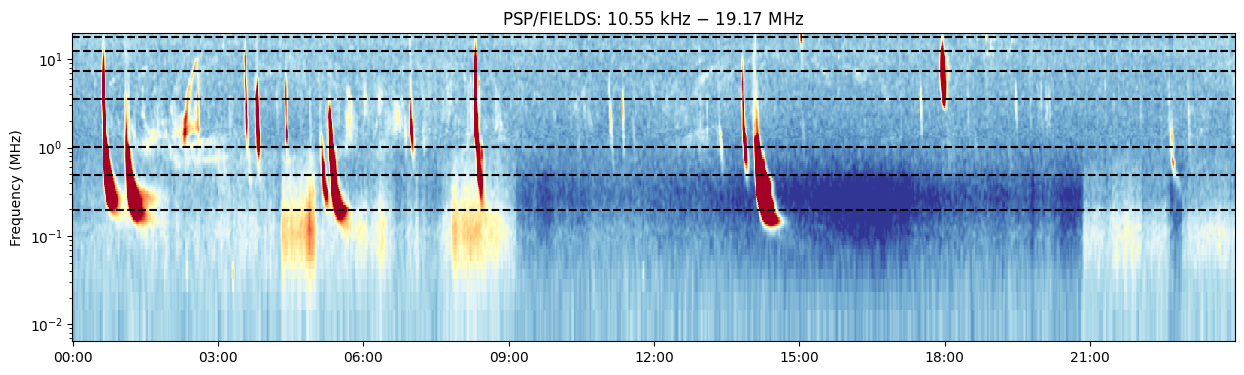

In [7]:
# skipped_channels = int(len(df_psp.index[df_psp.index > 1])/7)
# channels = df_psp.index[::skipped_channels]
# print(channels)

fig = plt.figure(figsize=[15,4])

ax = fig.add_subplot(111)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')

for channel in channels:
    ax.axhline(y=channel, color='k', linestyle='--')

ax.set_yscale('log')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

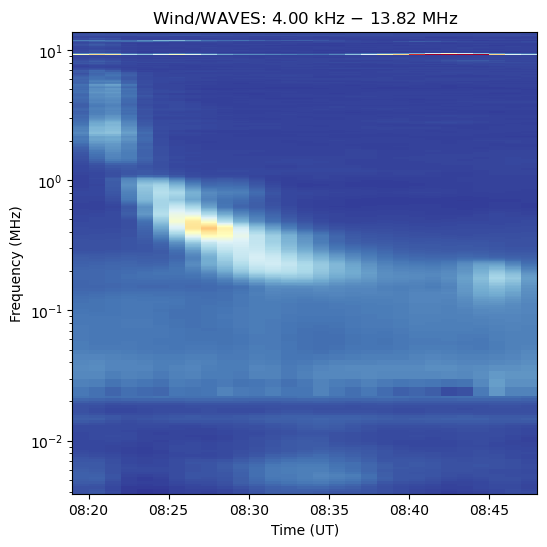

In [19]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 08:19'),
            right=pd.Timestamp('2021-09-18 08:48'))
plt.show()

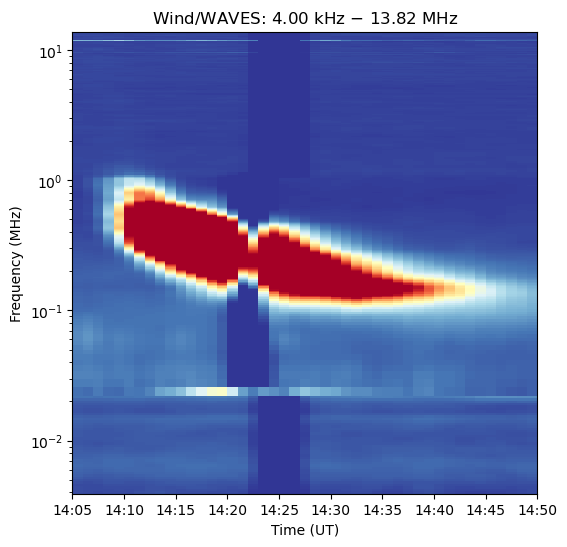

In [16]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.pcolormesh(wind_time,
               wind_freq/1e3,
               wind_data.T,
               norm=wind_norm,
               cmap='RdYlBu_r')
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2021-09-18 14:05'),
            right=pd.Timestamp('2021-09-18 14:50'))
plt.show()

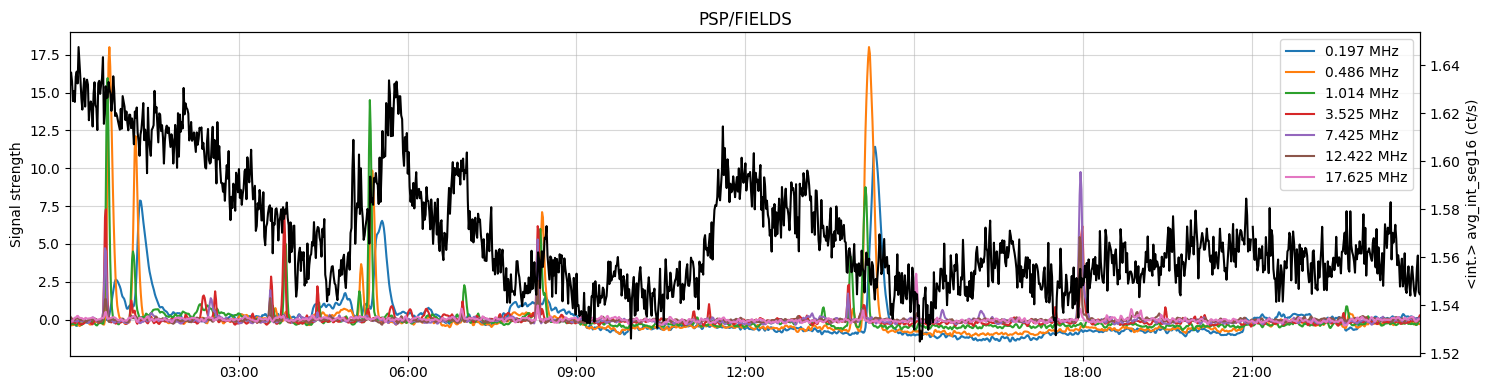

In [143]:
fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for channel in channels:
    ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')

ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Signal strength')
ax.set_title('PSP/FIELDS')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
fig.tight_layout()
plt.show()

In [145]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,8])
    
    ax = fig.add_subplot(211)
    for channel in channels:
        ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_ylabel('Signal strength')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
    
    ax = fig.add_subplot(212)
    ax.pcolormesh(df_psp.columns,
                   df_psp.index,
                   df_psp.values,
                   norm=psp_norm,
                   cmap='RdYlBu_r')
    for channel in channels:
        ax.axhline(y=channel, color='white', linestyle='--')
    
    ax.set_yscale('log')
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    axx.set_xlim(df.index[0], df.index[-1])
    
    fig.tight_layout()
    fig.savefig(f'./plots/psp_comparison_{t.date()}_{col}_{aia_channel}a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

Doing avg_int_seg1 ...
Doing avg_int_seg2 ...
Doing avg_int_seg3 ...
Doing avg_int_seg4 ...
Doing avg_int_seg5 ...
Doing avg_int_seg6 ...
Doing avg_int_seg7 ...
Doing avg_int_seg8 ...
Doing avg_int_seg9 ...
Doing avg_int_seg10 ...
Doing avg_int_seg11 ...
Doing avg_int_seg12 ...
Doing avg_int_seg13 ...
Doing avg_int_seg14 ...
Doing avg_int_seg15 ...
Doing avg_int_seg16 ...


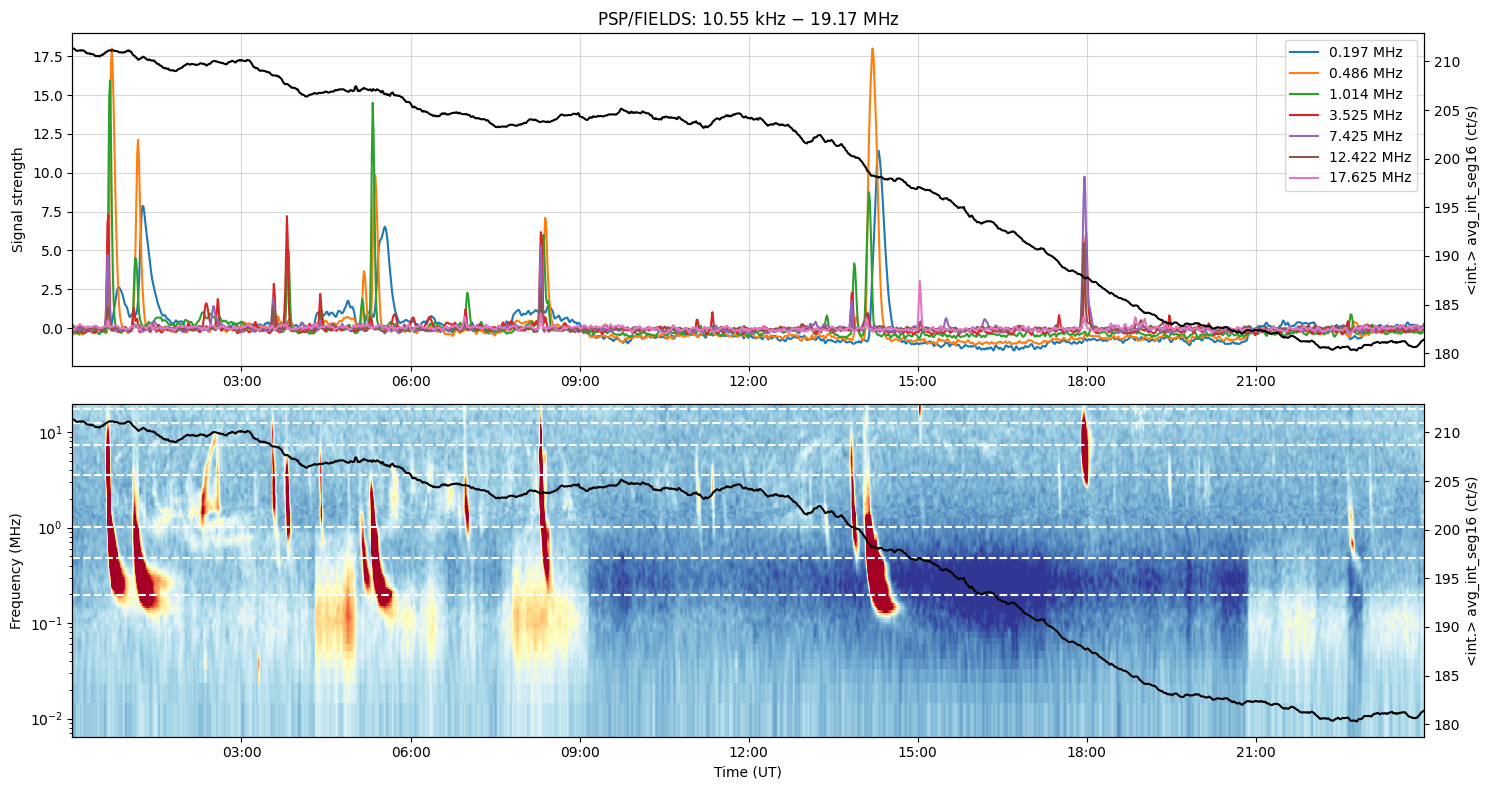

In [132]:
# Test

fig = plt.figure(figsize=[15,8])

ax = fig.add_subplot(211)
for channel in channels:
    ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')

ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Signal strength')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])

ax = fig.add_subplot(212)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
for channel in channels:
    ax.axhline(y=channel, color='white', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axx = ax.twinx()
axx.plot(df.index, df[col], color='k')
axx.set_ylabel(f'<int.> {col} (ct/s)')
axx.set_xlim(df.index[0], df.index[-1])

fig.tight_layout()
plt.show()

In [ ]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,4])
    ax = fig.add_subplot(111)

    for channel in channels:
        ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')

    axx = ax.twinx()
    axx.plot(df.index, df[col], color='k')
    axx.set_ylabel(f'<int.> {col} (ct/s)')
    
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_ylabel('Signal strength')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
    fig.tight_layout()
    fig.savefig(f'./plots/psp_comparison_{t.date()}_{col}_193a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# fig = plt.figure(figsize=[15,10])

# ax = fig.add_subplot(311)
# ax.pcolormesh(df_psp.columns,
#                df_psp.index,
#                df_psp.values,
#                norm=psp_norm,
#                cmap='RdYlBu_r')
# ax.set_yscale('log')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# axx = ax.twinx()
# axx.plot(df.index, df[col], color='k')
# axx.set_ylabel(f'<int.> {col} (ct/s)')
# axx.set_xlim(df.index[0], df.index[-1])

# ax = fig.add_subplot(312)
# ax.pcolormesh(time_ste,
#                freq_ste/1e3,
#                data_ste_A,
#                norm=ste_norm,
#                cmap='RdYlBu_r')
# ax.set_yscale('log')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(f"STEREO/SWAVES: {freq_ste[0]:.2f} kHz $-$ {freq_ste[-1]/1e3:.2f} MHz")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# axx = ax.twinx()
# axx.plot(df.index, df[col], color='k')
# axx.set_ylabel(f'<int.> {col} (ct/s)')
# axx.set_xlim(df.index[0], df.index[-1])

# ax = fig.add_subplot(313)
# ax.pcolormesh(wind_time,
#                wind_freq/1e3,
#                wind_data.T,
#                norm=wind_norm,
#                cmap='RdYlBu_r')
# ax.set_yscale('log')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_title(f"Wind/WAVES: {wind_freq[0]:.2f} kHz $-$ {wind_freq[-1]/1e3:.2f} MHz")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# axx = ax.twinx()
# axx.plot(df.index, df[col], color='k')
# axx.set_ylabel(f'<int.> {col} (ct/s)')
# axx.set_xlim(df.index[0], df.index[-1])

# fig.tight_layout()
# plt.show()

# Plot AIA 193 and 94 $A^o$ together ...

In [146]:
# Load the EUV intensity profiles, segments
df_94 = pd.read_csv(f'/home/mnedal/DIAS/mean_intensities_segments_94a.csv')
df_94['datetime'] = pd.to_datetime(df_94['datetime'])
df_94.set_index('datetime', inplace=True)
df_94.drop('Unnamed: 0', axis=1, inplace=True)

df_193 = pd.read_csv(f'/home/mnedal/DIAS/mean_intensities_segments_193a.csv')
df_193['datetime'] = pd.to_datetime(df_193['datetime'])
df_193.set_index('datetime', inplace=True)
df_193.drop('Unnamed: 0', axis=1, inplace=True)

# Replace values meeting condition with NaN in all columns
df_94 = df_94.applymap(lambda x: np.nan if x < 0.5 else x)
df_193 = df_193.applymap(lambda x: np.nan if x < 0.5 else x)

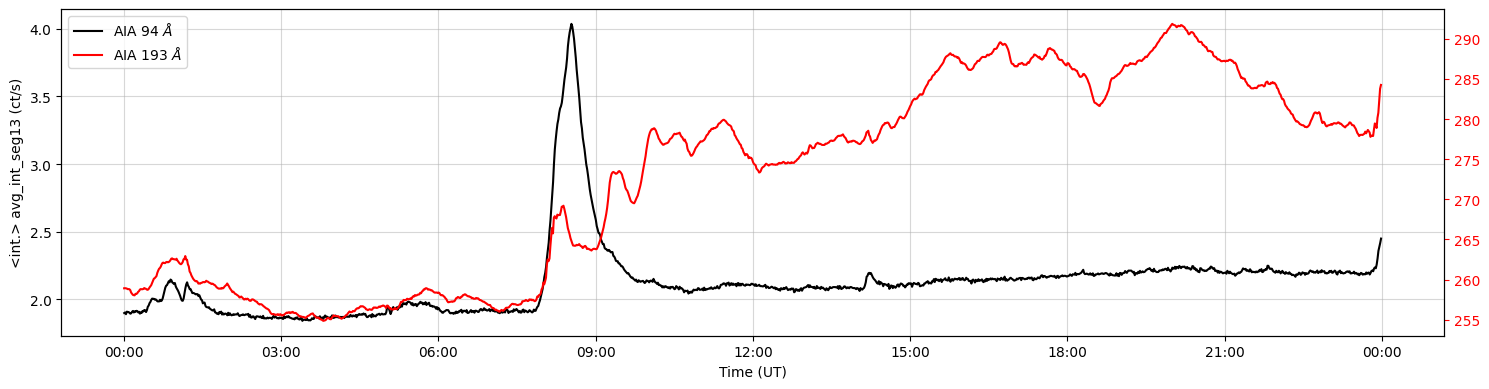

In [164]:
# Pick this column to plot
col = 'avg_int_seg13'

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

line94, = ax.plot(df_94.index, df_94[col], color='k', label='AIA 94 $\AA$')
axx = ax.twinx()
line193, = axx.plot(df_193.index, df_193[col], color='r', label='AIA 193 $\AA$')

# Set y-axis tick labels color to match line color
axx.tick_params(axis='y', colors='r')

# Combine legends
lines = [line94, line193]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

ax.set_xlabel('Time (UT)')
ax.set_ylabel(f'<int.> {col} (ct/s)')
ax.grid(alpha=0.5)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

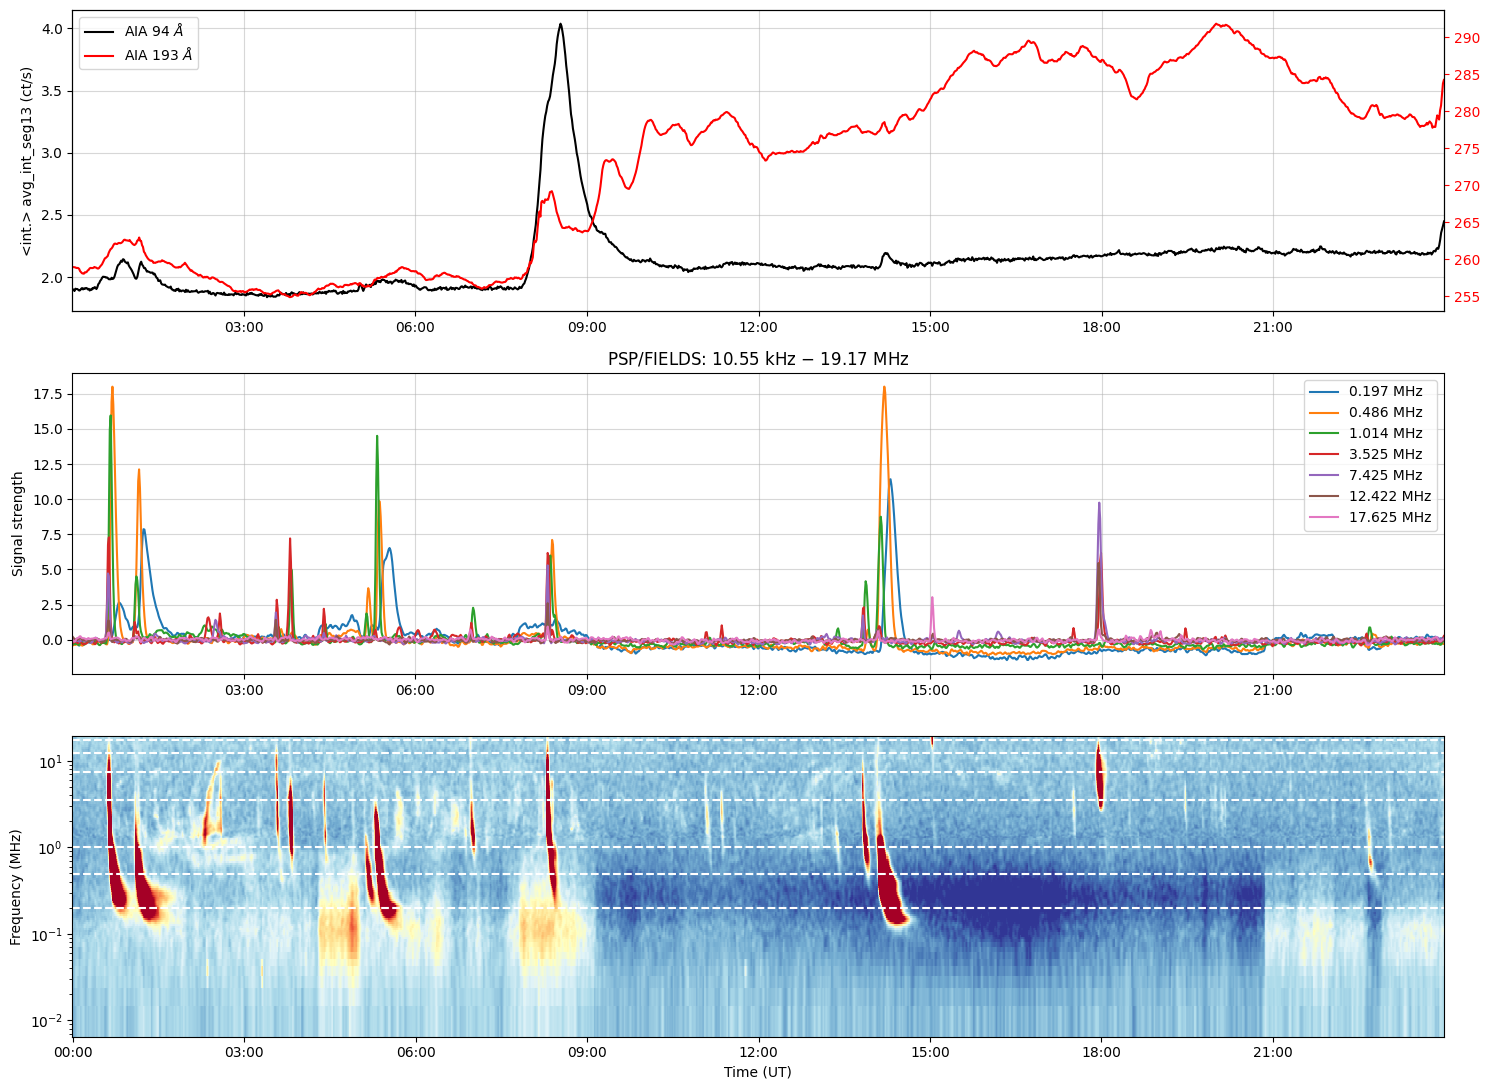

In [173]:
# Test
fig = plt.figure(figsize=[15,11])

ax = fig.add_subplot(311)
line94, = ax.plot(df_94.index, df_94[col], color='k', label='AIA 94 $\AA$')
axx = ax.twinx()
line193, = axx.plot(df_193.index, df_193[col], color='r', label='AIA 193 $\AA$')
axx.tick_params(axis='y', colors='r') # Set y-axis tick labels color to match line color
lines = [line94, line193] # Combine legends
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
ax.set_ylabel(f'<int.> {col} (ct/s)')
ax.grid(alpha=0.5)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_193.index[0], df_193.index[-1])

ax = fig.add_subplot(312)
for channel in channels:
    ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')
ax.legend()
ax.grid(alpha=0.5)
ax.set_ylabel('Signal strength')
ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])


ax = fig.add_subplot(313)
ax.pcolormesh(df_psp.columns,
               df_psp.index,
               df_psp.values,
               norm=psp_norm,
               cmap='RdYlBu_r')
for channel in channels:
    ax.axhline(y=channel, color='white', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.tight_layout()
plt.show()

In [174]:
# Doing a for loop ...
for col in df.columns:
    print(f'Doing {col} ...')
    
    fig = plt.figure(figsize=[15,11])

    ax = fig.add_subplot(311)
    line94, = ax.plot(df_94.index, df_94[col], color='k', label='AIA 94 $\AA$')
    axx = ax.twinx()
    line193, = axx.plot(df_193.index, df_193[col], color='r', label='AIA 193 $\AA$')
    axx.tick_params(axis='y', colors='r') # Set y-axis tick labels color to match line color
    lines = [line94, line193] # Combine legends
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc='upper left')
    ax.set_ylabel(f'<int.> {col} (ct/s)')
    ax.grid(alpha=0.5)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_193.index[0], df_193.index[-1])

    ax = fig.add_subplot(312)
    for channel in channels:
        ax.plot(df_psp.columns, df_psp.loc[channel], label=f'{channel:.3f} MHz')
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_ylabel('Signal strength')
    ax.set_title(f"PSP/FIELDS: {df_psp.index[0]*1e3:.2f} kHz $-$ {df_psp.index[-1]:.2f} MHz")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(df_psp.columns[0], df_psp.columns[-1])
    
    ax = fig.add_subplot(313)
    ax.pcolormesh(df_psp.columns,
                   df_psp.index,
                   df_psp.values,
                   norm=psp_norm,
                   cmap='RdYlBu_r')
    for channel in channels:
        ax.axhline(y=channel, color='white', linestyle='--')

    ax.set_yscale('log')
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.tight_layout()
    fig.savefig(f'./plots/psp_comparison_{t.date()}_{col}_{aia_channel}a.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

Doing avg_int_seg1 ...
Doing avg_int_seg2 ...
Doing avg_int_seg3 ...
Doing avg_int_seg4 ...
Doing avg_int_seg5 ...
Doing avg_int_seg6 ...
Doing avg_int_seg7 ...
Doing avg_int_seg8 ...
Doing avg_int_seg9 ...
Doing avg_int_seg10 ...
Doing avg_int_seg11 ...
Doing avg_int_seg12 ...
Doing avg_int_seg13 ...
Doing avg_int_seg14 ...
Doing avg_int_seg15 ...
Doing avg_int_seg16 ...
